# Metal Classifier

In this notebook, we train an XGBoost classifier to predict whether a system is metallic or not (bandgap <0.2 eV), and use this as an automated means of cleaning our dataset.

This notebook produces the results presented in Supporting Information Section "Metal Classification with XGBoost"

In [1]:
import copy

import pandas as pd
import numpy as np
import optuna
import xgboost
import imblearn.over_sampling
import sklearn.model_selection
import dscribe.descriptors
import tqdm
import sklearn.pipeline

import functools

import matplotlib.pyplot as plt
import sklearn.impute
import seaborn as sns

import sys
sys.path.append("../../../")
import DigitalEcosystem.utils.figures

tqdm.tqdm.pandas()

In [2]:
# Random seeds for reproducibility
RANDOM_SEED = 1234
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Read in the Dataset

In [3]:
# Load up the data
data_path = "../featurization/full_featurized_data.pkl"
data = pd.read_pickle(data_path)
target_column = ['bandgap (eV)']

# Featurization

Here, we use the Sine Matrix eigenspectrum (DScribe Documentation here: [Link](https://singroup.github.io/dscribe/0.3.x/tutorials/sine_matrix.html)) as our input feature to determine metallicity. We'd also tried the Ewald Summation Matrix eigenspectrum (DScribe Documentation here: [Link](https://singroup.github.io/dscribe/latest/tutorials/descriptors/ewald_sum_matrix.html)), but found that the Sine Matrix led to better performnance.

In [4]:
# Generate the Sine Matrix Fingerprint
max_atoms = max(data['atoms_object (unitless)'].apply(len))

sine_eigenspectrum = dscribe.descriptors.SineMatrix(n_atoms_max=max_atoms,
                                                    permutation='eigenspectrum',
                                                    sparse=False)

data['sine_matrix'] = data['atoms_object (unitless)'].progress_apply(lambda atoms: np.real(sine_eigenspectrum.create(atoms)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6351/6351 [00:13<00:00, 484.15it/s]


Next, we'll label our data. We'll say that it's a metal if its DFT bandgap is less than 0.2 eV.

In [5]:
# Manually label metals/nonmetals
bandgap_cutoff = 0.2

data['metal'] = data['bandgap (eV)'] < bandgap_cutoff
train, test = sklearn.model_selection.train_test_split(data, test_size=0.1, stratify=data['metal'], random_state=RANDOM_SEED)

# Train/Test Split
Then, we'll split up our data into a training and testing set. We'll stratify our dataset to ensure the same proportion of metals are found in both the training and test set.

In [6]:
# Pull out the X and Y values
def get_x_y(df):
    x = np.vstack(df['sine_matrix'])
    y = df['metal'].apply(int).to_numpy()
    return x,y
train_x, train_y = get_x_y(train)
test_x, test_y = get_x_y(test)

# K-Means SMOTE
At this point, our dataset is slightly imbalanced. To address this, we'll use the K-means variation of SMOTE (Imbalanced-Learn Documentation here: [Link](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.KMeansSMOTE.html)). This is a variation on SMOTE that first performs the K-Means algorithm to generate class labels within the minority class, and then upsamples those. It's shown very promising performance for imbalanced classification problems compared to the original SMOTE algorithm (Original publication hosted at https://arxiv.org/abs/1711.00837).

To avoid contaminating our test set with information about the training set, we perform K-means SMOTE *after* the train/test split.

In [7]:
# Upsample the training set with SMOTE
knn_smote = imblearn.over_sampling.KMeansSMOTE(
    random_state=RANDOM_SEED,
    k_neighbors = 4
)
res_x, res_y = knn_smote.fit_resample(train_x, train_y)

# Hyperparameter Optimization

For this work, we'll use an XGBoost classifier. Several of its most important hyperparameters are tuned via Optuna, a Bayesian optimization framework implented in Python.

In addition to optimizing the hyperparameters, we'll also investigate the use of a scaler. Optuna can choose from the following options:
1. No scaler being applied
2. A Min/Max scaler
3. A StandardScaler

In [8]:
current_pipeline = None
best_pipeline = None

def keep_best_bandgap_model(study, trial):
    """
    Records the best bandgap model found so far
    """
    global best_pipeline
    try:
        if study.best_trial == trial:
            best_pipeline = current_pipeline
    except ValueError:
        pass

def objective(trial: optuna.Trial):
    global current_pipeline

    objective_train_x, objective_validation_x, objective_train_y, objective_validation_y = sklearn.model_selection.train_test_split(res_x, res_y, test_size=0.2)

    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0, 1),
        'min_split_loss': trial.suggest_float('min_split_loss', 0, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2)
    }

    scalers = {
        "StandardScaler": sklearn.preprocessing.StandardScaler(),
        "MinMaxScaler": sklearn.preprocessing.MinMaxScaler()
    }

    scaler = trial.suggest_categorical('scaler', scalers.keys())

    current_pipeline = sklearn.pipeline.Pipeline([
        (scaler, scalers[scaler]),
        ("XGB_Classifier", xgboost.sklearn.XGBClassifier(**params,
                                               n_estimators=100,
                                               objective='binary:logistic',
                                               use_label_encoder=False,
                                               random_state=RANDOM_SEED),)
    ])

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'validation_0-auc')

    current_pipeline.fit(X=objective_train_x, y=objective_train_y,
                         **{
                            'XGB_Classifier__eval_set': [[objective_validation_x, objective_validation_y]],
                            'XGB_Classifier__eval_metric': 'auc',
                            'XGB_Classifier__early_stopping_rounds': 5,
                            'XGB_Classifier__callbacks': [pruning_callback],
                            'XGB_Classifier__verbose': False
                         })

    preds = current_pipeline.predict(objective_validation_x)
    pred_labels = np.rint(preds)
    f1 = sklearn.metrics.f1_score(objective_validation_y, pred_labels)

    return f1

We'll run Optuna using its TPE Sampler (the default; documentation here: [Link](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.TPESampler.html)) with a random seed supplied. Additionally, we'll use the HyperBand pruner to prune trials that are not promising (Documentation link here: [Link](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.HyperbandPruner.html)).

We choose the HyperBand pruner because it's demonstrated accelerate convergence faster than many of the other pruning techniques available in Optuna: [Blogpost Link](https://tech.preferred.jp/en/blog/how-we-implement-hyperband-in-optuna/)

In [9]:
study = optuna.create_study(
    sampler = optuna.samplers.TPESampler(
        seed=RANDOM_SEED,
        warn_independent_sampling=True,
        consider_endpoints=True,
    ),
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=100),
    direction='maximize',
)

[I 2021-10-04 11:58:56,294] A new study created in memory with name: no-name-36481190-5e75-489a-9723-f13bfff2652c


In [10]:
study.optimize(objective, n_trials=1000, callbacks=[keep_best_bandgap_model])

[I 2021-10-04 11:58:56,728] Trial 0 finished with value: 0.7261029411764706 and parameters: {'learning_rate': 0.1915194503788923, 'min_split_loss': 0.6221087710398319, 'max_depth': 44, 'min_child_weight': 7.853585837137692, 'reg_lambda': 1.559951616237607, 'reg_alpha': 0.5451852105652832, 'scaler': 'MinMaxScaler'}. Best is trial 0 with value: 0.7261029411764706.
[I 2021-10-04 11:58:56,840] Trial 1 finished with value: 0.7055793991416308 and parameters: {'learning_rate': 0.9581393536837052, 'min_split_loss': 0.8759326347420947, 'max_depth': 36, 'min_child_weight': 5.009951255234587, 'reg_lambda': 1.3669258703442726, 'reg_alpha': 1.4254040539658004, 'scaler': 'MinMaxScaler'}. Best is trial 0 with value: 0.7261029411764706.
[I 2021-10-04 11:58:56,869] Trial 2 pruned. Trial was pruned at iteration 1.
[I 2021-10-04 11:58:56,980] Trial 3 finished with value: 0.6855670103092784 and parameters: {'learning_rate': 0.9331401019825216, 'min_split_loss': 0.6513781432265774, 'max_depth': 40, 'min_ch

# ROC Curves

To assess model performance, we'll print out some ROC curves here.

Although we hold out a validation set in our objective function, we do not retrain the model on the entire training set, as this validation set was also used to control the early stopping of our XGBoost model (and thus helps guard against overfitting).

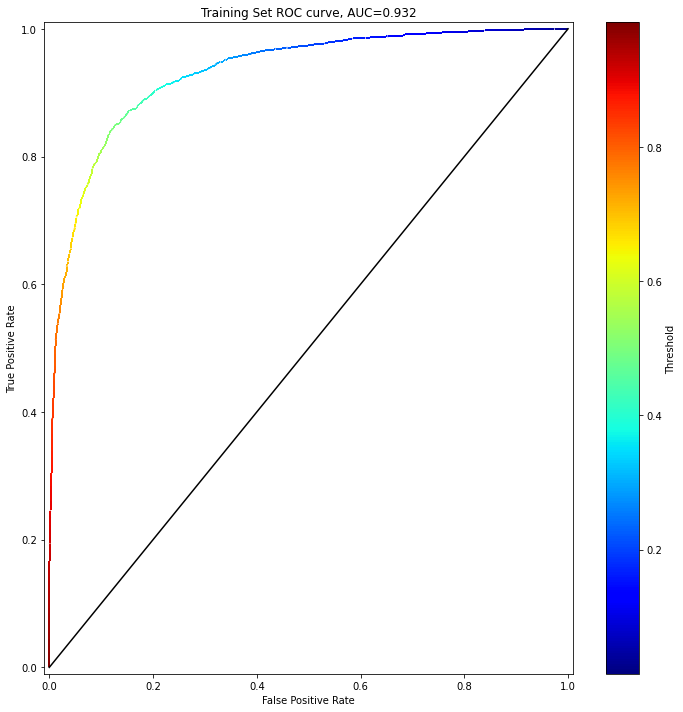

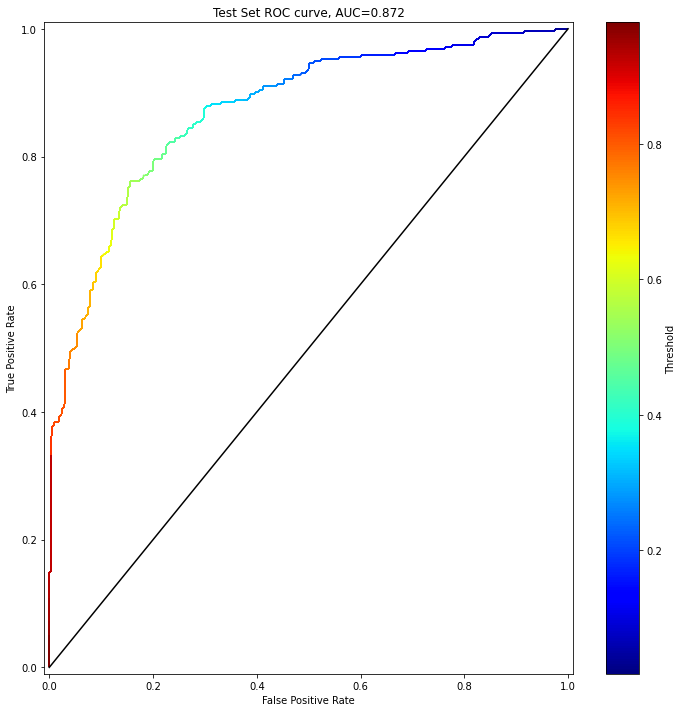

In [11]:
plot_roc = functools.partial(DigitalEcosystem.utils.figures.plot_roc, classifier=best_pipeline)

plot_roc(train_x, train_y, "Training")
plot_roc(test_x, test_y, "Test")

# Confusion Matrices

For a more fine-grained picture of our model's performance, we also draw confusion matrices here.

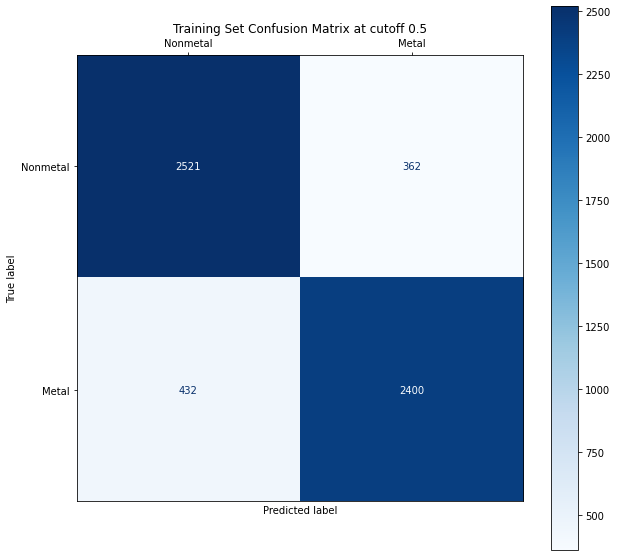

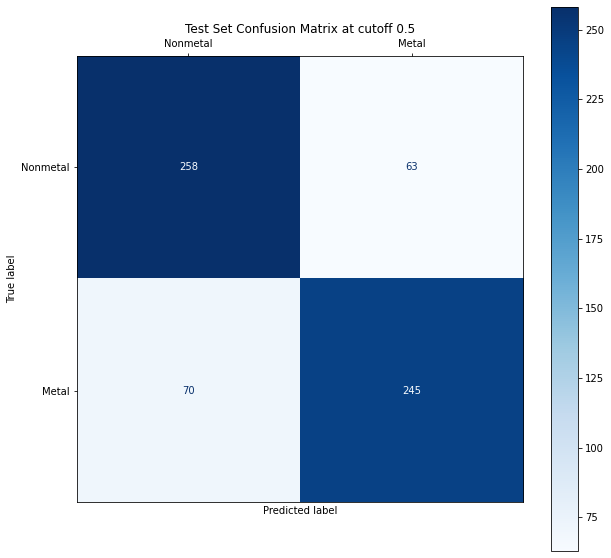

In [12]:
CUTOFF = 0.5


draw_confusion_matrix = functools.partial(DigitalEcosystem.utils.figures.draw_confusion_matrix,
                                          classifier=best_pipeline,
                                          cutoff=CUTOFF)

draw_confusion_matrix(train_x, train_y, "Training")
draw_confusion_matrix(test_x, test_y, "Test")

In [13]:
def calc_confusion_matrix_statistics(y_values, x_values, best_pipeline=best_pipeline):
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true=y_values, y_pred=best_pipeline.predict_proba(x_values)[:,1]>CUTOFF)
    
    all_positives = sum(y_values)
    all_negatives = len(y_values) - all_positives    
    
    true_positives = confusion_matrix[1,1]
    true_negatives = confusion_matrix[0,0]
    
    false_positives = confusion_matrix[0,1]
    false_negatives = confusion_matrix[1,0]

    results = {
        "TPR": true_positives / all_positives,
        "FPR": false_positives / all_negatives,
        "Accuracy": (true_positives + true_negatives) / (all_positives + all_negatives),
        "F1 Score": (2 * true_positives) / (2 * true_positives + false_positives + false_negatives),
        "ROC AUC": sklearn.metrics.roc_auc_score(y_true=y_values, y_score = best_pipeline.predict_proba(x_values)[:,1])
    }
    return results

print("Train statistics:")
for k,v in calc_confusion_matrix_statistics(train_y, train_x).items():
    print(k,np.round(v,3))
    
print("\nTest statistics:")
for k,v in calc_confusion_matrix_statistics(test_y, test_x).items():
    print(k,np.round(v,3))

Train statistics:
TPR 0.847
FPR 0.126
Accuracy 0.861
F1 Score 0.858
ROC AUC 0.932

Test statistics:
TPR 0.778
FPR 0.196
Accuracy 0.791
F1 Score 0.787
ROC AUC 0.872


# Nonmetal Bandgap Regression

Next, we'll move to the next step of our pipeline: predicting the bandgap of nonmetals.

We'll use our trained classifier to label the dataset as "metal" or "nonmetal."

In [14]:
train['pred_metal'] = copy.deepcopy(best_pipeline.predict_proba(train_x)[:,1] > CUTOFF)
test['pred_metal'] = copy.deepcopy(best_pipeline.predict_proba(test_x)[:,1] > CUTOFF)

/var/folders/44/wt0537cs00g919dkdsfqdq8w0000gn/T/ipykernel_13699/3887875597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['pred_metal'] = copy.deepcopy(best_pipeline.predict_proba(train_x)[:,1] > CUTOFF)
/var/folders/44/wt0537cs00g919dkdsfqdq8w0000gn/T/ipykernel_13699/3887875597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_metal'] = copy.deepcopy(best_pipeline.predict_proba(test_x)[:,1] > CUTOFF)


Next, we'll separate out the predicted nonmetals from our training and testing set.

In [15]:
train_metals = train[train['pred_metal'] == True]
train_nonmetals = train[train['pred_metal'] != True]

test_metals = test[test['pred_metal'] == True]
test_nonmetals = test[test['pred_metal'] != True]

# Regression - Features

Choose the set of features for the XGBoost regression model. Compositional and structural features.

In [16]:
xenonpy_descriptors = [col for col in data.columns if ":" in col]
matminer_descriptors = [
    'bond_length_average',
    'bond_angle_average',
    'average_cn',
    'global_instability',
    'perimeter_area_ratio',
    'ewald_energy_per_atom',
    'structural complexity per atom',
    'structural complexity per cell',
    'n_symmetry_ops'

]
xenonpy_matminer_descriptors = xenonpy_descriptors + matminer_descriptors#%%
target = ['bandgap (eV)']

Next, we'll separate out our X and Y columns, and we'll use Numpy to remove any NaN values that made their way into the dataset.

This is an area of improvement, as we could have also imputed the NaN values instead.

In [17]:
train_x_reg = np.nan_to_num(train_nonmetals[xenonpy_matminer_descriptors].to_numpy())
train_y_reg = np.nan_to_num(train_nonmetals[target].to_numpy())

test_x_reg = np.nan_to_num(test_nonmetals[xenonpy_matminer_descriptors].to_numpy())
test_y_reg = np.nan_to_num(test_nonmetals[target].to_numpy())

# Regression - XGBoost

Finally, we'll train another XGBoost model, this time for regression of the bandgap. We'll also draw a parity plot of our results.

[I 2021-10-04 12:00:54,296] A new study created in memory with name: no-name-307c93a9-7f9b-453d-8629-1f99823104a4
[I 2021-10-04 12:00:57,182] Trial 0 finished with value: 0.5873353793216511 and parameters: {'learning_rate': 0.1915194503788923, 'min_split_loss': 0.6221087710398319, 'max_depth': 44, 'min_child_weight': 7.853585837137692, 'reg_lambda': 1.559951616237607, 'reg_alpha': 0.5451852105652832, 'scaler': 'MinMaxScaler'}. Best is trial 0 with value: 0.5873353793216511.
[I 2021-10-04 12:00:57,262] Trial 1 pruned. Trial was pruned at iteration 1.
[I 2021-10-04 12:00:59,826] Trial 2 finished with value: 0.6591823684032302 and parameters: {'learning_rate': 0.5030831653078097, 'min_split_loss': 0.013768449590682241, 'max_depth': 78, 'min_child_weight': 8.826411906361166, 'reg_lambda': 0.7297719678027446, 'reg_alpha': 1.2307923568669874, 'scaler': 'MinMaxScaler'}. Best is trial 0 with value: 0.5873353793216511.
[I 2021-10-04 12:01:02,016] Trial 3 finished with value: 0.9281338736482235 

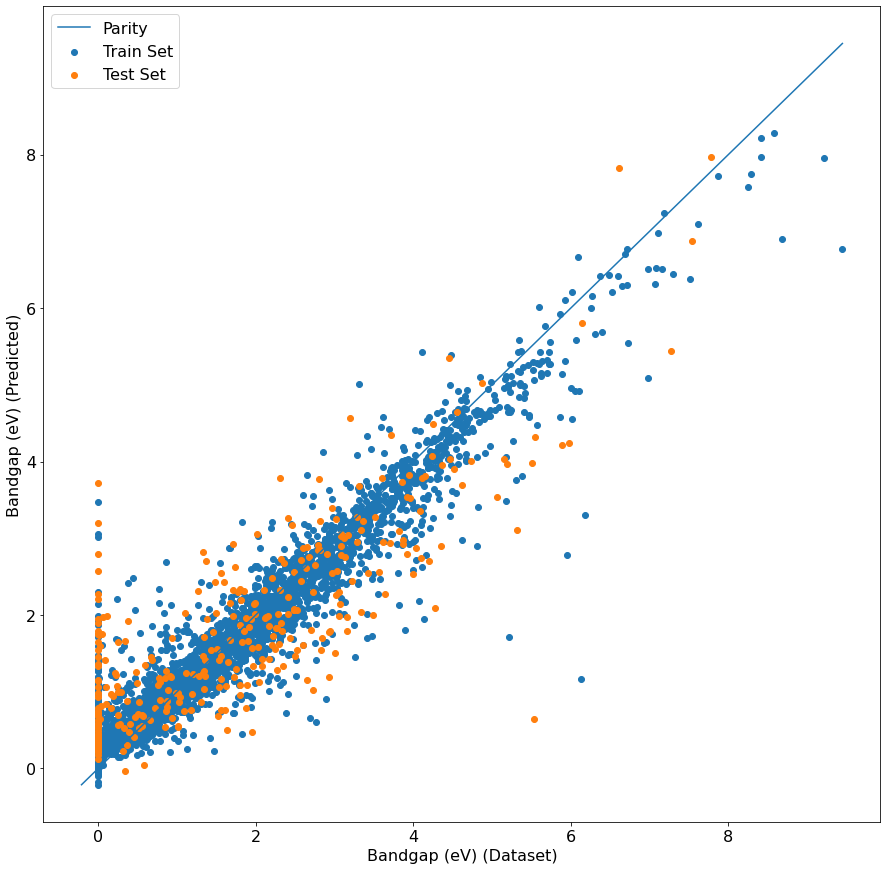

In [18]:
current_reg = None
best_reg = None
def keep_best_reg(study, trial):
    global best_reg
    if study.best_trial == trial:
        best_reg = current_reg

#TEST
objective_train_x_reg, objective_validation_x_reg, objective_train_y_reg, objective_validation_y_reg = sklearn.model_selection.train_test_split(
    np.nan_to_num(train_x_reg), train_y_reg, test_size=0.2, random_state=RANDOM_SEED)

def objective(trial: optuna.Trial):
    global current_reg


    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0, 1),
        'min_split_loss': trial.suggest_float('min_split_loss', 0, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2)
    }
    
    scalers = {
        "StandardScaler": sklearn.preprocessing.StandardScaler(),
        "MinMaxScaler": sklearn.preprocessing.MinMaxScaler()
    }

    scaler = trial.suggest_categorical('scaler', scalers.keys())

    current_reg = sklearn.pipeline.Pipeline([
        (scaler, scalers[scaler]),
        ("XGB_Regressor", xgboost.sklearn.XGBRegressor(**params,
                                               n_estimators=100,
                                               objective='reg:squarederror',
                                               random_state=RANDOM_SEED),)
    ])

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-poisson-nloglik')
    current_reg.fit(X=objective_train_x_reg, y=objective_train_y_reg,
                         **{
                            'XGB_Regressor__eval_set': [[objective_validation_x_reg, objective_validation_y_reg]],
                            'XGB_Regressor__eval_metric': 'poisson-nloglik',
                            'XGB_Regressor__early_stopping_rounds': 50,
                            'XGB_Regressor__callbacks': [pruning_callback],
                            'XGB_Regressor__verbose': False
                         })

    score = sklearn.metrics.mean_poisson_deviance(
        y_true=objective_validation_y_reg,
        y_pred=abs(current_reg.predict(objective_validation_x_reg)),
    )

    return score

reg_study = optuna.create_study(
    sampler = optuna.samplers.TPESampler(
        seed = RANDOM_SEED,
        warn_independent_sampling = True,
        consider_endpoints = True
    ),
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=100),
    direction='minimize'
)

reg_study.optimize(func=objective, n_trials=1000, callbacks=[keep_best_reg])

DigitalEcosystem.utils.figures.save_parity_plot(train_x_reg,
                                                test_x_reg,
                                                train_y_reg,
                                                test_y_reg,
                                                best_reg,
                                                "Bandgap (eV)",
                                                "parity.jpeg")

# Regression - Results


In [19]:
def rmse(y_true, y_pred):
    mse = sklearn.metrics.mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(abs(mse))
    return rmse

metrics = {
    'MaxError': sklearn.metrics.max_error,
    'MAE': sklearn.metrics.mean_absolute_error,
    'MSE': sklearn.metrics.mean_squared_error,
    'RMSE': rmse,
    'MAPE': sklearn.metrics.mean_absolute_percentage_error,
    'R2': sklearn.metrics.r2_score
}

y_pred_test = best_reg.predict(test_x_reg)
for key, fun in metrics.items():
    value = fun(y_true=test_y_reg, y_pred=y_pred_test)
    print(key,np.round(value,3))

MaxError 4.888
MAE 0.678
MSE 0.846
RMSE 0.92
MAPE 737249634671245.2
R2 0.669


# Regression - Feature Importances

Feature importance scores are from the regression model.

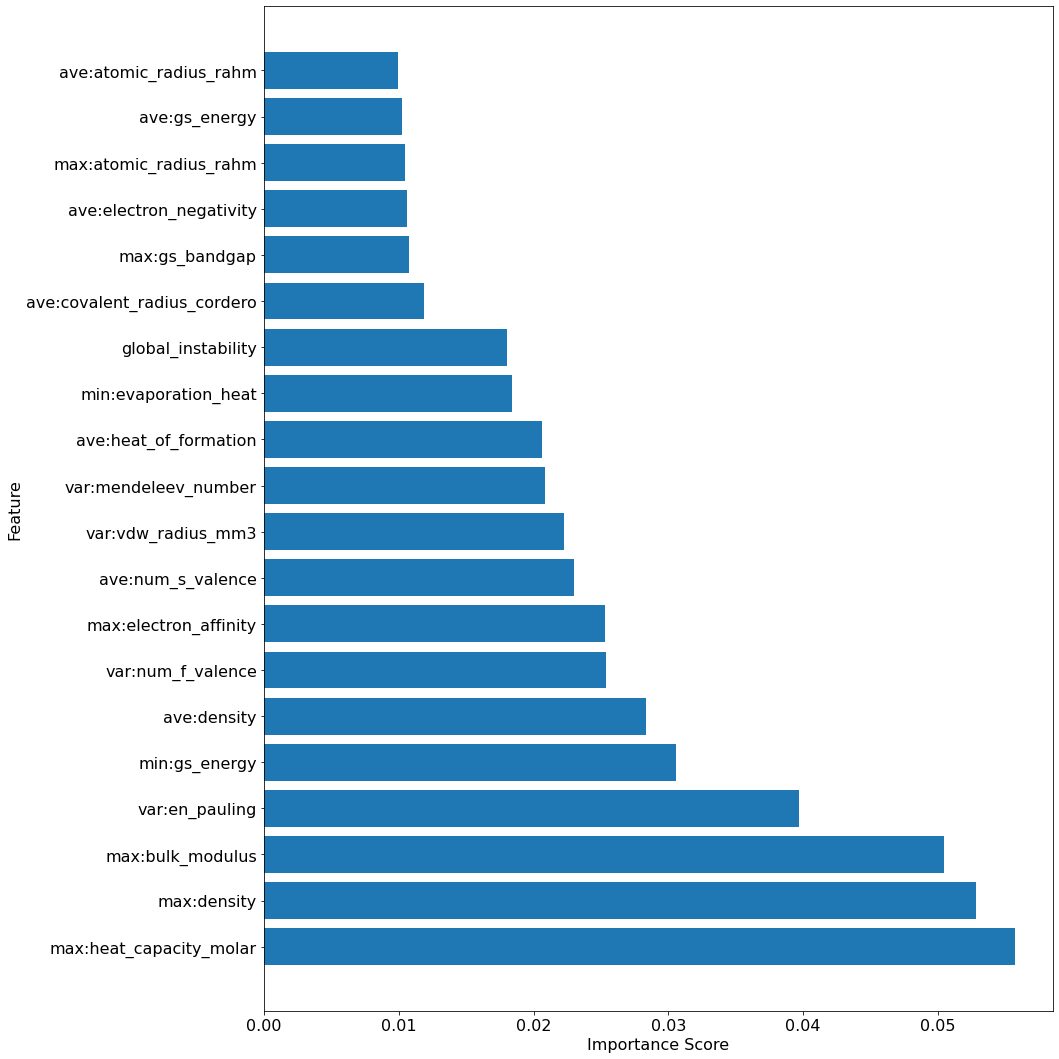

In [20]:
n_importances = 20
importances = list(zip(best_reg[1].feature_importances_, xenonpy_matminer_descriptors))

sorted_importances = list(sorted(importances, key=lambda i: -i[0]))



plt.barh(range(n_importances), [imp[0] for imp in sorted_importances[:n_importances]])
plt.yticks(range(n_importances), [imp[1] for imp in sorted_importances[:n_importances]])
plt.ylabel("Feature")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("Importances.jpeg")

# Conclusions

Overall, in this notebook we:

1. Trained a classifier to predict whether a material is likely to be a metal or a nonmetal, with very good performance.
2. Identified that our data seems to be Tweedie-Distributed once we remove the nonmetals - which might be contributing to some of the error in the model (the high density of points at 0 eV).
3. Trained a regression model to predict the bandgap, with MAE comparable to a graph convolutional neural network that had been trained to address the bandgap of similar materials.
4. Identified several features important to the prediction of the bandgap, as determined by the importance score of our XGBoost model.